In [97]:
from muFFT import FFT
import numpy as np
import matplotlib.pyplot as plt

def make_sphere(radius, nb_grid_pts, physical_sizes, centre=None,
                standoff="undefined",
                offset=0, periodic=False, kind="sphere",
                nb_subdomain_grid_pts=None, subdomain_locations=None):
    r"""
    Simple sphere geometry.

    If kind="sphere" (Default)

    .. math:: h = \left\{ \begin{array}{ll} \sqrt{\text{radius}^2 - r^2} -
                  \text{radius} & \text{  for  } r < \text{radius} \\ - \text{standoff}
                   & \text{else} \end{array} \right.

    If kind="paraboloid" the sphere is approximated by a paraboloid

    .. math:: h = \frac{r^2}{2 \cdot \text{radius}}

    :math:`r^2 = x^2 + y^2`

    Parameters
    ----------
    radius : float
        self-explanatory
    nb_grid_pts : float
        self-explanatory
    physical_sizes : float
        self-explanatory
    centre : float
         specifies the coordinates (in length units, not pixels).
         by default, the sphere is centred in the topography
    kind: str
        Options are "sphere" or "paraboloid". Default is "sphere".
    standoff : float or "undefined"
         when using interaction forces with ranges of the order
         the radius, you might want to set the topography outside of
         the sphere to far away, maybe even pay the price of inf,
         if your interaction has no cutoff

         For `standoff="undefined"`, the entries will be masked in the 
         topography and topography.has_undefined_data will be true

         If `kind="paraboloid"` the paraboloid approximation is used
            and the standoff is not applied
    periodic : bool
         whether the sphere can wrap around. tricky for large spheres
    """  # noqa: E501, W291
    if not hasattr(nb_grid_pts, "__iter__"):
        nb_grid_pts = (nb_grid_pts,)
    dim = len(nb_grid_pts)
    if not hasattr(physical_sizes, "__iter__"):
        physical_sizes = (physical_sizes,)
    if centre is None:
        centre = np.array(physical_sizes) * .5
    if not hasattr(centre, "__iter__"):
        centre = (centre,)

    if not periodic:
        def get_r(res, size, centre, subd_loc, subd_res):
            " computes the non-periodic radii to evaluate"
            x = (subd_loc + np.arange(subd_res)) * size / res
            return x - centre
    else:
        def get_r(res, size, centre, subd_loc, subd_res):
            " computes the periodic radii to evaluate"
            x = (subd_loc + np.arange(subd_res)) * size / res
            return (x - centre + size / 2) % size - size / 2

    if dim == 1:
        r2 = get_r(nb_grid_pts[0], physical_sizes[0], centre[0],
                   subdomain_locations[0], nb_subdomain_grid_pts[0]) ** 2
    elif dim == 2:
        #print(nb_grid_pts[0], physical_sizes[0], centre[0],
        #             subdomain_locations[0],nb_subdomain_grid_pts[0])
        rx2 = (get_r(nb_grid_pts[0], physical_sizes[0], centre[0],
                     subdomain_locations[0],
                     nb_subdomain_grid_pts[0]) ** 2).reshape((-1, 1))
        #print(nb_grid_pts[1], physical_sizes[1], centre[1],
        #             subdomain_locations[1], nb_subdomain_grid_pts[1])
        ry2 = (get_r(nb_grid_pts[1], physical_sizes[1], centre[1],
                     subdomain_locations[1], nb_subdomain_grid_pts[1])) ** 2
        r2 = rx2 + ry2
        print(r2)
    else:
        raise ValueError("Problem has to be 1- or 2-dimensional. "
                         "Yours is {}-dimensional".format(dim))

    if kind == "sphere":
        radius2 = radius ** 2  # avoid nans for small radii
        outside = r2 > radius2
        r2[outside] = radius2
        h = np.sqrt(radius2 - r2) - radius
        if standoff == "undefined":
            standoff_val = np.nan
        else:
            standoff_val = - standoff - radius
        h[outside] = standoff_val
    elif kind == "paraboloid":
        h = - r2 / (2 * radius)
    else:
        raise (ValueError("Wrong value given for parameter kind {}. "
                          "Should be 'sphere' or 'paraboloid'".format(kind)))
    return h
    '''if dim == 1:
        ret_top = UniformLineScan(h + offset, physical_sizes)
    else:
        ret_top = Topography(h + offset, physical_sizes,
                             decomposition='subdomain',
                             nb_grid_pts=nb_grid_pts,
                             subdomain_locations=subdomain_locations,
                             communicator=communicator)

    if standoff == "undefined":
        return ret_top
    else:
        return ret_top.fill_undefined_data(standoff_val)'''

In [104]:
def get_r(res, size, centre, subd_loc, subd_res):
            " computes the non-periodic radii to evaluate"
            x = (subd_loc + np.arange(subd_res)) * size / res
            return x- centre

s = (get_r( 6, 6., 3.0, 0, 6)**2 ).reshape((-1, 1))
s2 = (get_r(6, 6.0, 3.0, 0, 6)**2)
print(s)
print(s2)
print(s+s2)
#fig, ax = plt.subplots()
#ax.imshow(s+s2)
#plt.show()

[[9.]
 [4.]
 [1.]
 [0.]
 [1.]
 [4.]]
[9. 4. 1. 0. 1. 4.]
[[18. 13. 10.  9. 10. 13.]
 [13.  8.  5.  4.  5.  8.]
 [10.  5.  2.  1.  2.  5.]
 [ 9.  4.  1.  0.  1.  4.]
 [10.  5.  2.  1.  2.  5.]
 [13.  8.  5.  4.  5.  8.]]


[[18.         16.94214876 15.95041322 ... 15.02479339 15.95041322
  16.94214876]
 [16.94214876 15.88429752 14.89256198 ... 13.96694215 14.89256198
  15.88429752]
 [15.95041322 14.89256198 13.90082645 ... 12.97520661 13.90082645
  14.89256198]
 ...
 [15.02479339 13.96694215 12.97520661 ... 12.04958678 12.97520661
  13.96694215]
 [15.95041322 14.89256198 13.90082645 ... 12.97520661 13.90082645
  14.89256198]
 [16.94214876 15.88429752 14.89256198 ... 13.96694215 14.89256198
  15.88429752]]


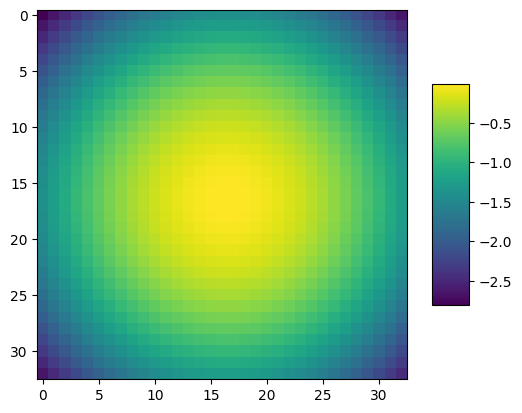

In [108]:

nx = 33
ny = 33
sx = 6.
sy = 6.
R = 3.2
center = (3., 3.)
fftengine = FFT((nx, ny))
#print(fftengine.nb_subdomain_grid_pts)
#print(fftengine.subdomain_locations)

extended_topography = make_sphere(
    R, (nx, ny), (sx, sy),
    centre=center,
    nb_subdomain_grid_pts=fftengine.nb_subdomain_grid_pts,
    subdomain_locations=fftengine.subdomain_locations,kind="paraboloid",
    periodic=True)
fig,ax = plt.subplots()
surf = ax.imshow(extended_topography)
plt.colorbar(surf, shrink=0.6, aspect=6)
#print(extended_topography)

In [ ]:
extended_topography2 = make_sphere(
    R, (nx, ny), (sx, sy),
    centre=center,
    nb_subdomain_grid_pts=fftengine.nb_subdomain_grid_pts,
    subdomain_locations=fftengine.subdomain_locations,
    periodic=True, kind='paraboloid')
#fig,ax = plt.subplots()
#ax.imshow(extended_topography2)


In [ ]:
'''
extended_topography = make_sphere(
    R, (nx, ny), (sx, sy),
    centre=center,
    nb_subdomain_grid_pts=fftengine.nb_subdomain_grid_pts,
    subdomain_locations=fftengine.subdomain_locations,
    periodic=True)

X, Y, Z = extended_topography.positions_and_heights()

np.testing.assert_allclose(
    (X - np.where(X < center[0] + sx / 2, center[0], center[0] + sx)) ** 2
    + (Y - np.where(Y < center[1] + sy / 2, center[1],
                    center[1] + sy)) ** 2
    + (R + Z) ** 2, R ** 2)'''

In [87]:
one = np.array((1,2,3)).reshape(-1,1)
two = np.array((2,3,4,5,6))
print(one+two)

[[3 4 5 6 7]
 [4 5 6 7 8]
 [5 6 7 8 9]]
